<a href="https://colab.research.google.com/github/HikariJadeEmpire/Image_classification_DeepLearning/blob/main/MobileNet_with_Augmentation_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Google drive
- List GPU
- Check libraries version

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]

NumPy 1.23.5

Matplotlib 3.7.1

TensorFlow 2.14.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 0 GPU(s):


# Import images
- Split Train & Test data

In [ ]:
import os
import cv2
import random

def train_test_split(main_dir,categories,n_train=70) :

  IMG_SIZE = 224
  train_data =[]
  test_data =[]

  for category in categories:
    path = os.path.join(main_dir, category)
    cat = categories.index(category)

    for i,img in enumerate(os.listdir(path)):
      try:
        img_array = cv2.imread(os.path.join(path,img))
        img_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
      except Exception as e :
        print("Something went wrong : {e}".format(e=e))

      if i <= n_train :
        train_data.append([img_array,cat])
      else :
        test_data.append([img_array,cat])

  random.seed(112) # Set seed to fix random output
  random.shuffle(train_data)
  random.shuffle(test_data)

  x_train=[]; y_train=[]
  x_test=[]; y_test=[]

  for features in train_data:
    x_train.append(features[0])
    y_train.append(features[1])

  for features in test_data:
    x_test.append(features[0])
    y_test.append(features[1])

  try:
    x_train = np.array(x_train, dtype='uint8').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    x_test = np.array(x_test, dtype='uint8').reshape(-1, IMG_SIZE, IMG_SIZE, 3)

    y_train = np.array(y_train, dtype='uint8').reshape(-1, 1)
    y_test = np.array(y_test, dtype='uint8').reshape(-1, 1)

  except Exception as e :
        print("Something went wrong : {e}".format(e=e))

  return [x_train, y_train , x_test, y_test]

In [ ]:
main_dir = "drive/MyDrive/myColab_Notebooks/DeepLearning/Banknote_img_data" # Your Google drive's images directory
categories = ["twenty","fifty","hundred","fivehundred","thousand"] # categories will become classes of 0,1,2,...

x_train, y_train , x_test, y_test = train_test_split(main_dir,categories)

# example result
print(x_train[0].shape)
print(x_train.shape)
print(y_train.shape)

(224, 224, 3)
(355, 224, 224, 3)
(355, 1)


In [ ]:
print("Train = {a} , Test = {b}".format(a=len(x_train), b=len(x_test)) )

Train = 355 , Test = 188


## _EDA

In [ ]:
print(type(x_train), type(x_train[0]), x_train[0].dtype, x_train.shape)
print(type(x_test), type(x_test[0]), x_test[0].dtype, x_test.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> uint8 (355, 224, 224, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> uint8 (188, 224, 224, 3)


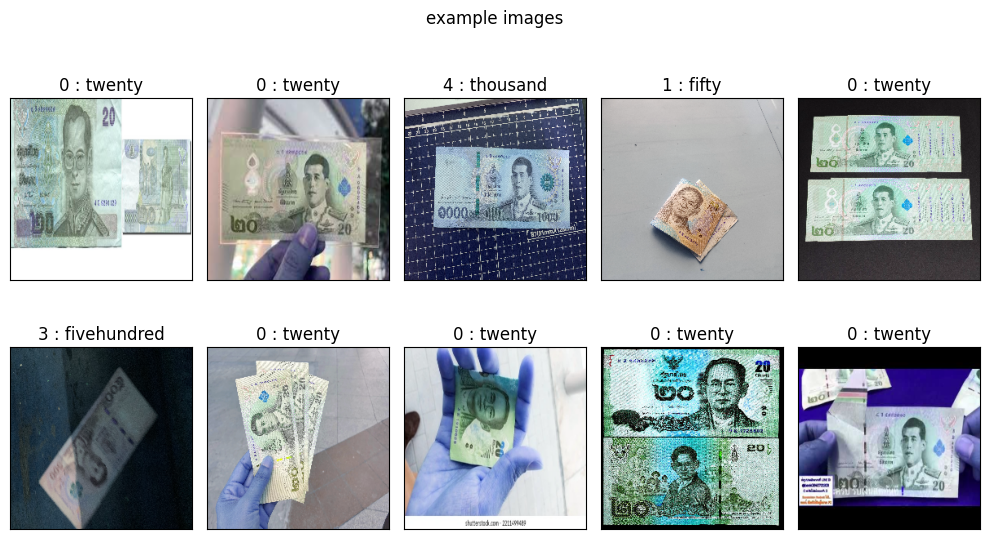

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,6), subplot_kw = {'xticks':[],'yticks':[]} )

n = 0
for i,img in zip(y_train,x_train) :
  if n < 10 :
    axes.flat[n].imshow(img)
    axes.flat[n].set_title(f"{i[0]} : {categories[i[0]]}")
    n+=1
  else: break

fig.suptitle("example images")
fig.tight_layout()
fig.show()

## _Change data type

In [ ]:
x_train = tf.keras.applications.mobilenet.preprocess_input(x_train)
x_test = tf.keras.applications.mobilenet.preprocess_input(x_test)

# check
print(type(x_train), type(x_train[0]), x_train[0].dtype, x_train.shape)
print(type(x_test), type(x_test[0]), x_test[0].dtype, x_test.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> float32 (355, 224, 224, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> float32 (188, 224, 224, 3)


# CNN Model import
- Non-adjust selected model
- Adjust selected model

In [ ]:
# Set fixed seeding values for reproducability during experiments
np.random.seed(23)
tf.random.set_seed(56)

## _Non-adjust MobileNet
 - but dropping the classifier and

In [ ]:
mobile = tf.keras.applications.MobileNet(
    include_top=True,
    weights="imagenet",
    classifier_activation="softmax"
)

mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

### __Prediction

In [ ]:
pred = mobile.predict( x_train[0:2] )

# Decode the top 10 classes
pred = tf.keras.applications.mobilenet.decode_predictions(pred, top=5)

1/1 [==============================] - 1s 882ms/step


In [ ]:
for i, prediction in enumerate(pred):
  print(f"\nImage No.{i+1}\n")
  for pp in prediction:
    print( f"Rank {i+1}: {pp}" )


Image No.1

Rank 1: ('n07248320', 'book_jacket', 0.4341027)
Rank 1: ('n03291819', 'envelope', 0.19808613)
Rank 1: ('n06596364', 'comic_book', 0.106006324)
Rank 1: ('n04317175', 'stethoscope', 0.024716387)
Rank 1: ('n03223299', 'doormat', 0.021698512)

Image No.2

Rank 2: ('n03666591', 'lighter', 0.2028417)
Rank 2: ('n02786058', 'Band_Aid', 0.14238648)
Rank 2: ('n03314780', 'face_powder', 0.05178497)
Rank 2: ('n03825788', 'nipple', 0.04768581)
Rank 2: ('n03908618', 'pencil_box', 0.041380037)


## _Adjust MobileNet

In [ ]:
inp_shape = ( 124,124,3 )

mobile = tf.keras.applications.MobileNet(
    input_shape=inp_shape,
    include_top=False,
    weights="imagenet",
)

mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 124, 124, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 62, 62, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 62, 62, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 62, 62, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 62, 62, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 62, 62, 32) 

### __Access and unfreeze layer(s) in Keras's model

In [ ]:
# Recursively freeze all layers in the model

mobile.trainable = False

ly = 80

for i,layer in enumerate(mobile.layers):
  if (ly-3) < i < ly :
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )
  elif i == ly :
    layer.trainable = True
    print( f"\nLayer {i}: name = {layer.name} , trainable = {layer.trainable}" )
  elif ly < i < (ly+4) :
    layer.trainable = True
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 78: name = conv_pw_12_bn , trainable = False
Layer 79: name = conv_pw_12_relu , trainable = False

Layer 80: name = conv_dw_13 , trainable = True
Layer 81: name = conv_dw_13_bn , trainable = True
Layer 82: name = conv_dw_13_relu , trainable = True
Layer 83: name = conv_pw_13 , trainable = True


### __Build Additional layer

In [ ]:
# additional = tf.keras.models.Sequential( [
#                                           tf.keras.Input( shape=(3,3,1024) ),
#                                           tf.keras.layers.DepthwiseConv2D(3,strides=1,padding='same',  use_bias=False),
#                                           tf.keras.layers.BatchNormalization(),
#                                           tf.keras.layers.ReLU(),

#                                           tf.keras.layers.Conv2D(1024, 1,use_bias=False),
#                                           tf.keras.layers.BatchNormalization(),
#                                           tf.keras.layers.ReLU(),

#                                           tf.keras.layers.DepthwiseConv2D(3,strides=1,padding='same',  use_bias=False),
#                                           tf.keras.layers.BatchNormalization(),
#                                           tf.keras.layers.ReLU(),

#                                           tf.keras.layers.Conv2D(1024, 1,use_bias=False),
#                                           tf.keras.layers.BatchNormalization(),
#                                           tf.keras.layers.ReLU(),

#                                       ],
#                                      name='additional_layer' )

# additional.summary()

### __Combine all layers

In [ ]:
# Data augmentation

inp = tf.keras.Input( shape=(224,224,3), name = 'myInput' )
x = tf.keras.layers.RandomFlip(mode='horizontal_and_vertical', name='rand_flip')(inp)
x = tf.keras.layers.RandomRotation(factor=0.2, fill_mode='constant', name='rand_rot')(x)
x = tf.keras.layers.RandomBrightness( factor=0.2 )(x)
x = tf.keras.layers.RandomContrast( factor=0.3 )(x)
x = tf.keras.layers.RandomCrop( 124, 124, seed=None )(x)

# MobileNet

x = mobile(x)
# x = additional(x)

# Classifier

x = tf.keras.layers.GlobalAveragePooling2D( keepdims=True, name='Glob_AvPooling' )(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Conv2D( filters=5, kernel_size=1, strides=(1, 1), activation=None, padding="valid", name='conv_preds' )(x)
x = tf.keras.layers.Reshape((-1,))(x)
out = tf.keras.layers.Activation('softmax')(x)

# Construct the main model

model = tf.keras.Model(inp, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 myInput (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rand_flip (RandomFlip)      (None, 224, 224, 3)       0         
                                                                 
 rand_rot (RandomRotation)   (None, 224, 224, 3)       0         
                                                                 
 random_brightness (RandomB  (None, 224, 224, 3)       0         
 rightness)                                                      
                                                                 
 random_contrast (RandomCon  (None, 224, 224, 3)       0         
 trast)                                                          
                                                                 
 random_crop (RandomCrop)    (None, 124, 124, 3)       0     

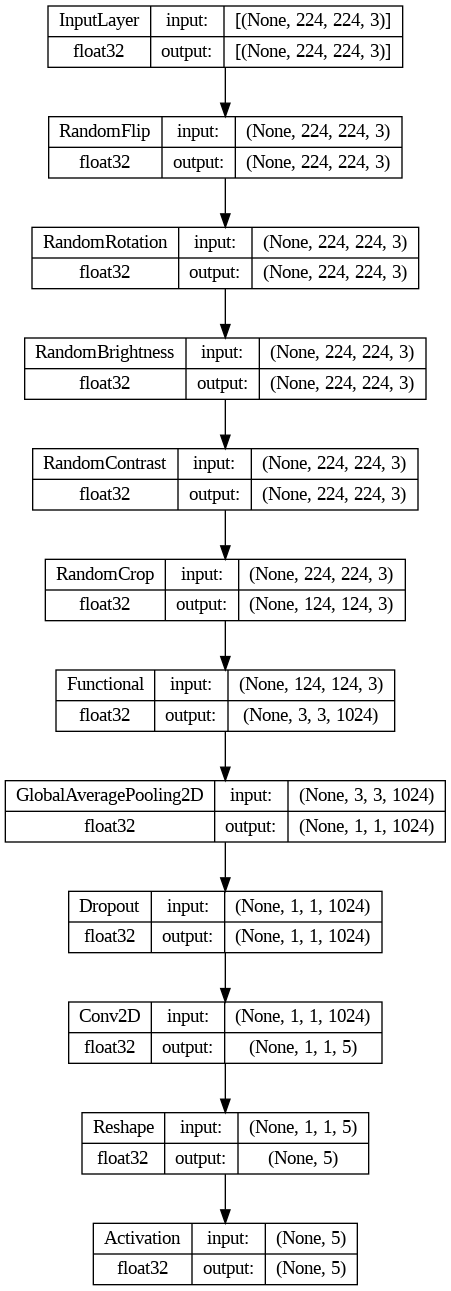

In [ ]:
tf.keras.utils.plot_model(model, to_file='cnn1_sequential.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

# Compile and train the model

In [ ]:
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

In [ ]:
# save model & weights every epoch

checkpoint_path = "drive/MyDrive/myColab_Notebooks/DeepLearning/weight_n_bias/MobileNet_bestmodel_round01.h5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                verbose=0,
                                                                save_best_only=True
                                                               )

## _Load weights & model

In [ ]:
# model.load_weights(checkpoint_path)

## _Train

In [ ]:
# Train the model
his = model.fit( x_train, y_train, batch_size=120,
                            epochs=200,
                            verbose=1,
                            validation_split=0.2,
                            callbacks=[model_checkpoint_callback]
                      )

Epoch 1/200
3/3 [==============================] - 24s 5s/step - loss: 2.0461 - acc: 0.1725 - val_loss: 3.0825 - val_acc: 0.1831
Epoch 2/200
3/3 [==============================] - 6s 2s/step - loss: 1.9198 - acc: 0.1901 - val_loss: 3.1389 - val_acc: 0.1972
Epoch 3/200
3/3 [==============================] - 10s 4s/step - loss: 1.8648 - acc: 0.1972 - val_loss: 3.2828 - val_acc: 0.2254
Epoch 4/200
3/3 [==============================] - 5s 2s/step - loss: 1.9380 - acc: 0.2218 - val_loss: 3.3316 - val_acc: 0.2113
Epoch 5/200
3/3 [==============================] - 8s 2s/step - loss: 1.8738 - acc: 0.2042 - val_loss: 3.2174 - val_acc: 0.1972
Epoch 6/200
3/3 [==============================] - 6s 2s/step - loss: 1.9592 - acc: 0.2007 - val_loss: 3.2330 - val_acc: 0.1831
Epoch 7/200
3/3 [==============================] - 8s 3s/step - loss: 1.9229 - acc: 0.2077 - val_loss: 3.3719 - val_acc: 0.1972
Epoch 8/200
3/3 [==============================] - 6s 2s/step - loss: 1.9665 - acc: 0.1937 - val_loss:

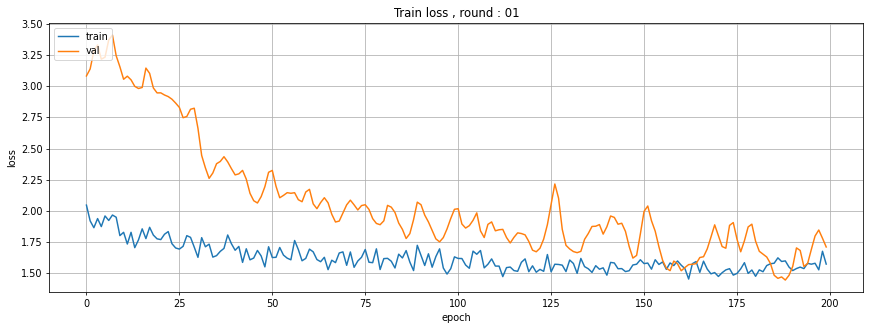

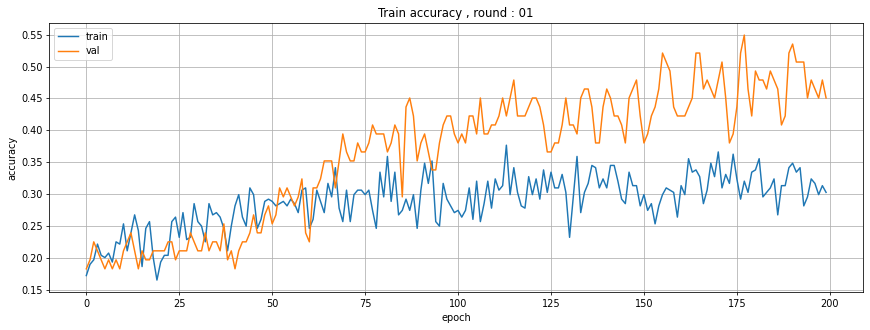

In [ ]:
round = '01'

# Summarize history for loss
plt.figure(figsize=(15,5), dpi = 70)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Train loss , round : '+round)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5), dpi = 70)
plt.plot(his.history['acc'])
plt.plot(his.history['val_acc'])
plt.title('Train accuracy , round : '+round)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Evaluate the model on test set

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=30)
print( f"{model.metrics_names} = {results}" )

7/7 [==============================] - 2s 242ms/step - loss: 1.9246 - acc: 0.3617
['loss', 'acc'] = [1.924607515335083, 0.3617021143436432]


## _Inspect Results

In [ ]:
plt.rcParams["axes.linewidth"] = 5

def color_frame( ax, y_true, y_pred ):
  color = 'green' if (y_true == y_pred) else 'red'
  ax.spines['bottom'].set_color(color)
  ax.spines['top'].set_color(color)
  ax.spines['right'].set_color(color)
  ax.spines['left'].set_color(color)

samples.shape=(10, 224, 224, 3)
1/1 [==============================] - 1s 986ms/step


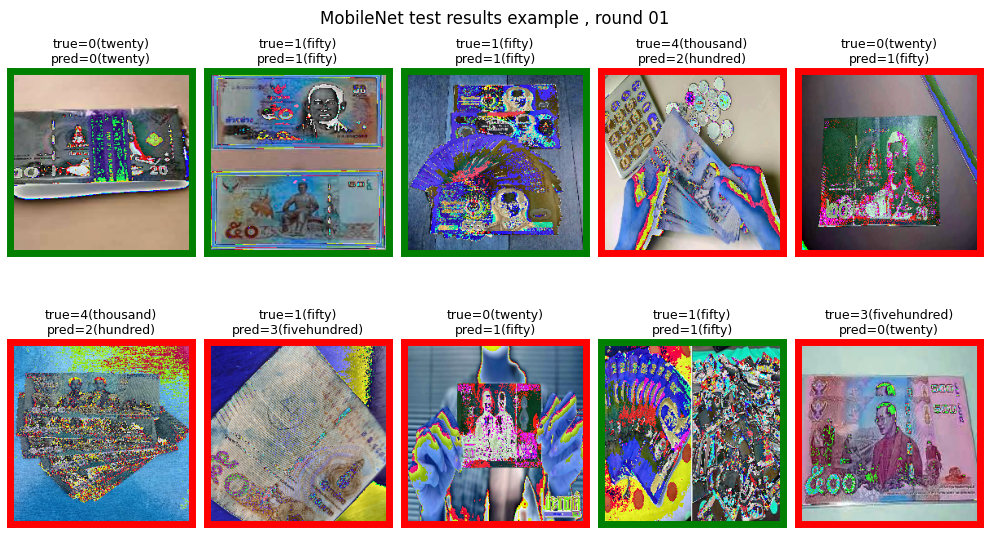

In [ ]:
# Get a batch of samples
n = 10
samples = x_test[:n]
print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = model.predict(samples)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,6), subplot_kw = {'xticks':[],'yticks':[]} )

# Interpret the results
for i in range(n):
  axes.flat[i].imshow(np.uint8(x_test[i]*255))
  axes.flat[i].set_title( f"true={y_test[i][0]}({categories[int(y_test[i])]})\npred={np.argmax(y_pred[i])}({categories[np.argmax(y_pred[i])]})"
                         , fontsize=9 )
  color_frame(axes.flat[i], y_test[i], np.argmax(y_pred[i]))

fig.tight_layout()
fig.suptitle("MobileNet test results example , round "+round)
fig.show()

## _get scores

In [ ]:
his.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
mymin = np.min(his.history['val_loss'])

lc = his.history['val_loss'].index(mymin)

print(f"Minimum validation loss scores :\n\n acc : {his.history['acc'][lc]}\n val_acc : {his.history['val_acc'][lc]}\n loss : {his.history['loss'][lc]}\n val_loss : {mymin}")

Minimum validation loss scores :

 acc : 0.31338027119636536
 val_acc : 0.4225352108478546
 loss : 1.5984857082366943
 val_loss : 1.4446972608566284


# Grad-CAM

In [ ]:
layer_name = 'mobilenet_1.00_224'  # Example layer name

intermediate_layer_model = tf.keras.Model(inputs=[model.inputs],
                  outputs=[model.get_layer(layer_name).get_layer('conv_pw_13_relu').output,
                  model.output])

intermediate_layer_model.layers.name

ValueError: ignored